In [1]:
from tensorflow import keras
import tensorflow as tf
from keras import models
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import img_to_array
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import rcParams
import cv2 as cv2
import copy
import sklearn.metrics
from sklearn.linear_model import Ridge
import math
from PIL import Image

import skimage.segmentation as ss
from skimage.segmentation import mark_boundaries as sb

In [2]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
num_classes = dataset_info.features['label'].num_classes
print(f"num_classes: {num_classes}")

num_classes: 5


In [4]:
class_names = dataset_info.features['label'].names
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 3303
Total Number of Validation Images: 367 



In [6]:
IMAGE_RES = 224
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 150
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [7]:
image_batch, label_batch = next(iter(validation_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [8]:
model = models.load_model('ResNet50')

In [9]:
test_sample, _ = next(iter(validation_batches))

In [11]:
test_image = test_sample[20].numpy()

In [12]:
def n_top_classes(image):
    predicted_label_res = model.predict(image[np.newaxis,...])
    predicted_label_res = tf.squeeze(predicted_label_res).numpy()
    class_sorted = np.argsort(predicted_label_res)[::-1]
    for i, pred in enumerate(class_sorted):
        print("Top {} predicted class: {}   class name: {}   predicted_prob: {:.5f}"
              .format(i+1, class_sorted[i], class_names[pred], predicted_label_res[pred]))
    return class_sorted[0], class_names[class_sorted[0]], predicted_label_res[class_sorted[0]]

In [13]:
print("Sample image:")
top_class, class_name, predicted_prob = n_top_classes(test_image)

Sample image:
Top 1 predicted class: 2   class name: tulips   predicted_prob: 0.98139
Top 2 predicted class: 4   class name: roses   predicted_prob: 0.01850
Top 3 predicted class: 1   class name: daisy   predicted_prob: 0.00009
Top 4 predicted class: 3   class name: sunflowers   predicted_prob: 0.00002
Top 5 predicted class: 0   class name: dandelion   predicted_prob: 0.00000


In [14]:
def s_slic(image, compactness, n_segments):
    superpixels = ss.slic(image.astype('double'), compactness=compactness, n_segments=n_segments)
    num_superpixels = np.unique(superpixels).shape[0]
    return superpixels, num_superpixels

#Create function to apply perturbations to images
def perturb_image(image, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(image)
    perturbed_image = perturbed_image * mask[:,:,np.newaxis]
    return perturbed_image

def heatmap(active_features, coeff_features, superpixels):
    #active_pixels = np.where(active_features == 1)[0]
    active_pixels = np.where(coeff_features !=1)[0]
    mask_coeff = np.zeros(superpixels.shape)
    for active in active_pixels:
        mask_coeff[superpixels == active] = coeff_features[active]
    heatmap =  mask_coeff[:,:]
    return heatmap

def xai_lime(image, superpixels, num_superpixels, class_explain):
# Parameters
    num_perturbations = 10 * num_superpixels
    #num_top_features = num_superpixels
    num_top_features = math.ceil(0.4*num_superpixels)
    predictions = []
    kernel_width = 0.25
    simpler_model = Ridge(alpha=0)   
    perturbations = np.random.binomial(1, 0.5, size=(num_perturbations, num_superpixels))

    for p in perturbations:
        perturbed_image = perturb_image(image, p, superpixels)
        prediction = model.predict(perturbed_image[np.newaxis,...])
        predictions.append(prediction)
    predictions=np.array(predictions)

#Compute distances to original image
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

#Transform distances to a value between 0 and 1 (weights) using a kernel function
     
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

#Estimate linear model
    class_to_explain = class_explain
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
    top_features = np.argsort(coeff)[-num_top_features:] 
    features = np.zeros(num_superpixels) 
    features[top_features]= True #Activate top superpixels
    resutls_xai = perturb_image(image, features, superpixels)
    return weights, perturbations, predictions, resutls_xai, num_top_features, features, coeff

In [15]:
def n_top_classes(image):
    predicted_label_res = model.predict(image[np.newaxis,...])
    predicted_label_res = tf.squeeze(predicted_label_res).numpy()
    class_sorted = np.argsort(predicted_label_res)[::-1]
    for i, pred in enumerate(class_sorted):
        print("Top {} predicted class: {}   class name: {}   predicted_prob: {:.5f}"
              .format(i+1, class_sorted[i], class_names[pred], predicted_label_res[pred]))
    return class_sorted[0], class_names[class_sorted[0]], predicted_label_res[class_sorted[0]]

In [16]:
seg1, n_seg1 = s_slic(test_image, 20,16)
seg2, n_seg2 = s_slic(test_image, 20,25)
seg3, n_seg3 = s_slic(test_image, 20,36)
seg4, n_seg4 = s_slic(test_image, 20,49)
seg5, n_seg5 = s_slic(test_image, 20,64)
seg6, n_seg6 = s_slic(test_image, 20,81)
seg7, n_seg7 = s_slic(test_image, 20,100)
seg8, n_seg8 = s_slic(test_image, 20,121)
seg9, n_seg9 = s_slic(test_image, 20,144)
seg10, n_seg10 = s_slic(test_image, 20,169)
seg11, n_seg11 = s_slic(test_image, 20,196)
seg12, n_seg12 = s_slic(test_image, 20,225)
seg13, n_seg13 = s_slic(test_image, 20,256)
seg14, n_seg14 = s_slic(test_image, 20,289)
seg15, n_seg15 = s_slic(test_image, 20,324)
seg16, n_seg16 = s_slic(test_image, 20,361)
seg17, n_seg17 = s_slic(test_image, 20,400)

C:\Users\hoori\AppData\Local\Temp/ipykernel_23672/4148549768.py:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  superpixels = ss.slic(image.astype('double'), compactness=compactness, n_segments=n_segments)


In [17]:
segments = [16,25,36,49,64,81,100,121,144,169,196,225,256,289,324,361,400]
sqr_segments = np.sqrt(segments)

In [18]:
num_segments = [n_seg1,n_seg2,n_seg3,n_seg4,n_seg5,n_seg6,n_seg7,n_seg8,
               n_seg9,n_seg10,n_seg11,n_seg12,n_seg13,n_seg14,n_seg15,n_seg16,n_seg17]

In [19]:
multi_scale = pd.DataFrame(data=[segments,num_segments],
                              columns=sqr_segments,
                              index=['Desired num of segments',
                                     'num of segmnets']).rename_axis('Square root of desired number of segments',axis='columns')
multi_scale

Square root of desired number of segments  4.0   5.0   6.0   7.0   8.0   9.0   \
Desired num of segments                      16    25    36    49    64    81   
num of segmnets                              12    17    32    41    59    74   

Square root of desired number of segments  10.0  11.0  12.0  13.0  14.0  15.0  \
Desired num of segments                     100   121   144   169   196   225   
num of segmnets                              86   109   132   151   175   201   

Square root of desired number of segments  16.0  17.0  18.0  19.0  20.0  
Desired num of segments                     256   289   324   361   400  
num of segmnets                             220   257   317   324   355

In [20]:
weights1, samples1, predicted_probs1, seg1_slic, top_f_seg1, features_seg1, coeff_seg1 = xai_lime(test_image, seg1, n_seg1, top_class)
weights2, samples2, predicted_probs2, seg2_slic, top_f_seg2, features_seg2, coeff_seg2 = xai_lime(test_image, seg2, n_seg2, top_class)
weights3, samples3, predicted_probs3, seg3_slic, top_f_seg3, features_seg3, coeff_seg3 = xai_lime(test_image, seg3, n_seg3, top_class)
weights4, samples4, predicted_probs4, seg4_slic, top_f_seg4, features_seg4, coeff_seg4 = xai_lime(test_image, seg4, n_seg4, top_class)
weights5, samples5, predicted_probs5, seg5_slic, top_f_seg5, features_seg5, coeff_seg5 = xai_lime(test_image, seg5, n_seg5, top_class)
weights6, samples6, predicted_probs6, seg6_slic, top_f_seg6, features_seg6, coeff_seg6 = xai_lime(test_image, seg6, n_seg6, top_class)
weights7, samples7, predicted_probs7, seg7_slic, top_f_seg7, features_seg7, coeff_seg7 = xai_lime(test_image, seg7, n_seg7, top_class)
weights8, samples8, predicted_probs8, seg8_slic, top_f_seg8, features_seg8, coeff_seg8 = xai_lime(test_image, seg8, n_seg8, top_class)
weights9, samples9, predicted_probs9, seg9_slic, top_f_seg9, features_seg9, coeff_seg9 = xai_lime(test_image, seg9, n_seg9, top_class)
weights10, samples10, predicted_probs10, seg10_slic, top_f_seg10, features_seg10, coeff_seg10 = xai_lime(test_image, seg10, n_seg10, top_class)
weights11, samples11, predicted_probs11, seg11_slic, top_f_seg11, features_seg11, coeff_seg11 = xai_lime(test_image, seg11, n_seg11, top_class)
weights12, samples12, predicted_probs12, seg12_slic, top_f_seg12, features_seg12, coeff_seg12 = xai_lime(test_image, seg12, n_seg12, top_class)
weights13, samples13, predicted_probs13, seg13_slic, top_f_seg13, features_seg13, coeff_seg13 = xai_lime(test_image, seg13, n_seg13, top_class)
weights14, samples14, predicted_probs14, seg14_slic, top_f_seg14, features_seg14, coeff_seg14 = xai_lime(test_image, seg14, n_seg14, top_class)
weights15, samples15, predicted_probs15, seg15_slic, top_f_seg15, features_seg15, coeff_seg15 = xai_lime(test_image, seg15, n_seg15, top_class)
weights16, samples16, predicted_probs16, seg16_slic, top_f_seg16, features_seg16, coeff_seg16 = xai_lime(test_image, seg16, n_seg16, top_class)
weights17, samples17, predicted_probs17, seg17_slic, top_f_seg17, features_seg17, coeff_seg17 = xai_lime(test_image, seg17, n_seg17, top_class)

In [21]:
heatmap_seg1 = heatmap(features_seg1, coeff_seg1, seg1)
heatmap_seg2 = heatmap(features_seg2, coeff_seg2, seg2)
heatmap_seg3 = heatmap(features_seg3, coeff_seg3, seg3)
heatmap_seg4 = heatmap(features_seg4, coeff_seg4, seg4)
heatmap_seg5 = heatmap(features_seg5, coeff_seg5, seg5)
heatmap_seg6 = heatmap(features_seg6, coeff_seg6, seg6)
heatmap_seg7 = heatmap(features_seg7, coeff_seg7, seg7)
heatmap_seg8 = heatmap(features_seg8, coeff_seg8, seg8)
heatmap_seg9 = heatmap(features_seg9, coeff_seg9, seg9)
heatmap_seg10 = heatmap(features_seg10, coeff_seg10, seg10)
heatmap_seg11 = heatmap(features_seg11, coeff_seg11, seg11)
heatmap_seg12 = heatmap(features_seg12, coeff_seg12, seg12)
heatmap_seg13 = heatmap(features_seg13, coeff_seg13, seg13)
heatmap_seg14 = heatmap(features_seg14, coeff_seg14, seg14)
heatmap_seg15 = heatmap(features_seg15, coeff_seg15, seg15)
heatmap_seg16 = heatmap(features_seg16, coeff_seg16, seg16)
heatmap_seg17 = heatmap(features_seg17, coeff_seg17, seg17)

In [22]:
multi_heatmaps = [heatmap_seg1,heatmap_seg2,heatmap_seg3,heatmap_seg4,
                  heatmap_seg5,heatmap_seg6,heatmap_seg7,heatmap_seg8,
                  heatmap_seg9,heatmap_seg10,heatmap_seg11,heatmap_seg12,
                 heatmap_seg13,heatmap_seg14,heatmap_seg15,heatmap_seg16,heatmap_seg17]

coefficients = [coeff_seg1,coeff_seg2,coeff_seg3,coeff_seg4,coeff_seg5,coeff_seg6,
               coeff_seg7,coeff_seg8,coeff_seg9,coeff_seg10,coeff_seg11,coeff_seg12,
               coeff_seg13,coeff_seg14,coeff_seg15,coeff_seg16,coeff_seg17]

In [23]:
min_coef = []
max_coef = []
for i in range(len(coefficients)):
    min_coef.append(np.min(coefficients[i]))
    max_coef.append(np.max(coefficients[i]))

In [24]:
negative=[]
positive=[]
for i in range(len(coefficients)):
    positive.append(np.count_nonzero(coefficients[i]>0))
    negative.append(np.count_nonzero(coefficients[i]<0))
coefficients_df = pd.DataFrame(data=[positive,negative,segments,num_segments],
                              columns=sqr_segments,
                              index=['Positive','Negative',
                                     'Desired num of segments',
                                     'Num of segmnets']).rename_axis('Sqr of desired num of segments',axis='columns')
coefficients_df

Sqr of desired num of segments  4.0   5.0   6.0   7.0   8.0   9.0   10.0  \
Positive                           9     8    13    14    28    44    46   
Negative                           3     9    19    27    31    30    40   
Desired num of segments           16    25    36    49    64    81   100   
Num of segmnets                   12    17    32    41    59    74    86   

Sqr of desired num of segments  11.0  12.0  13.0  14.0  15.0  16.0  17.0  \
Positive                          52    72    77   103   114   113   156   
Negative                          57    60    74    72    87   107   101   
Desired num of segments          121   144   169   196   225   256   289   
Num of segmnets                  109   132   151   175   201   220   257   

Sqr of desired num of segments  18.0  19.0  20.0  
Positive                         180   186   204  
Negative                         137   138   151  
Desired num of segments          324   361   400  
Num of segmnets                  317   324   355

#### Min and Max values per heatmap before normalization

In [25]:
min_val = []
max_val = []
for i in range(len(multi_heatmaps)):
    min_val.append(np.min(multi_heatmaps[i]))
    max_val.append(np.max(multi_heatmaps[i]))
heatmaps_val = pd.DataFrame(data=[min_val, max_val], 
                            columns=sqr_segments,
                            index=['Min','Max']).rename_axis('Sqr of desired n_segments',axis='columns')
heatmaps_val

Sqr of desired n_segments      4.0       5.0       6.0       7.0       8.0   \
Min                       -0.070629 -0.195147 -0.216496 -0.158489 -0.098454   
Max                        0.594730  0.251608  0.244751  0.320301  0.251438   

Sqr of desired n_segments      9.0       10.0      11.0      12.0      13.0  \
Min                       -0.086241 -0.072295 -0.064679 -0.059446 -0.058616   
Max                        0.229054  0.247746  0.162789  0.198071  0.131734   

Sqr of desired n_segments      14.0      15.0      16.0      17.0     18.0  \
Min                       -0.048718 -0.122651 -0.043515 -0.038745 -0.04544   
Max                        0.111376  0.118213  0.063322  0.077124  0.08207   

Sqr of desired n_segments      19.0      20.0  
Min                       -0.036067 -0.035762  
Max                        0.069090  0.075759

In [27]:
#### Normalizing heatmaps
for i in range(len(multi_heatmaps)):
    multi_heatmaps[i] = (multi_heatmaps[i]-np.min(multi_heatmaps[i]))/(np.max(multi_heatmaps[i])-np.min(multi_heatmaps[i]))
#### Min and Max values per heatmap after normalization
min_val = []
max_val = []
for i in range(len(multi_heatmaps)):
    min_val.append(np.min(multi_heatmaps[i]))
    max_val.append(np.max(multi_heatmaps[i]))
heatmaps_val = pd.DataFrame(data=[min_val, max_val], 
                            columns=num_segments,
                            index=['Min','Max']).rename_axis('Heatmaps',axis='columns')

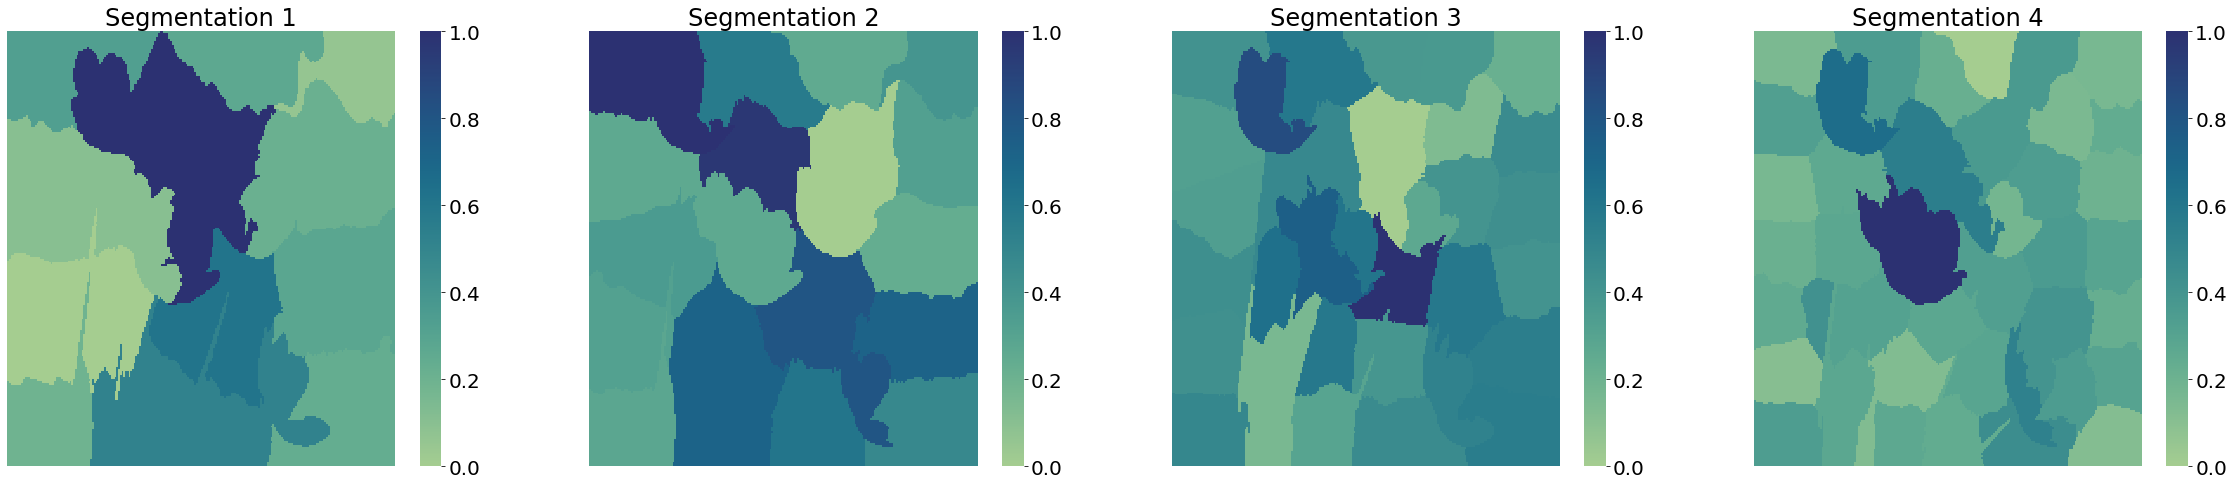

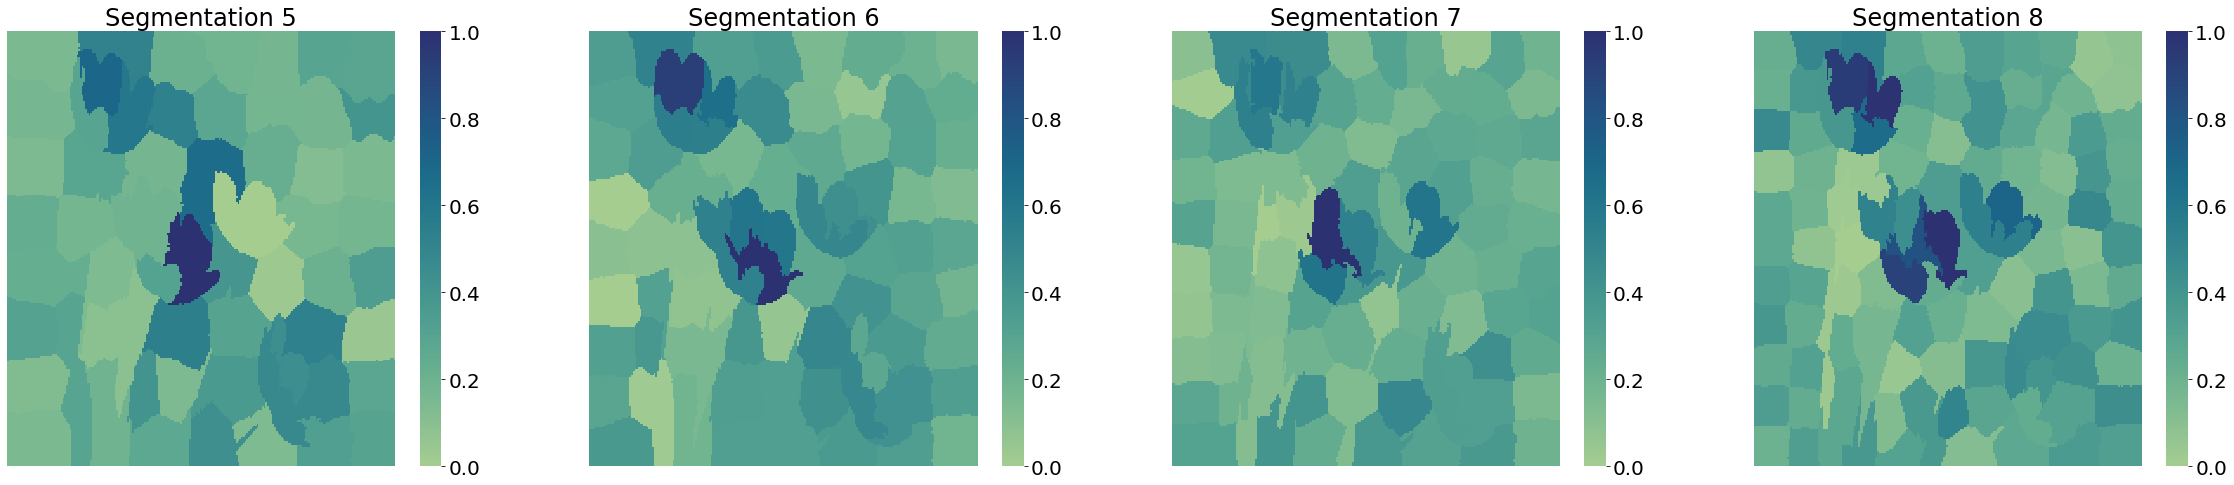

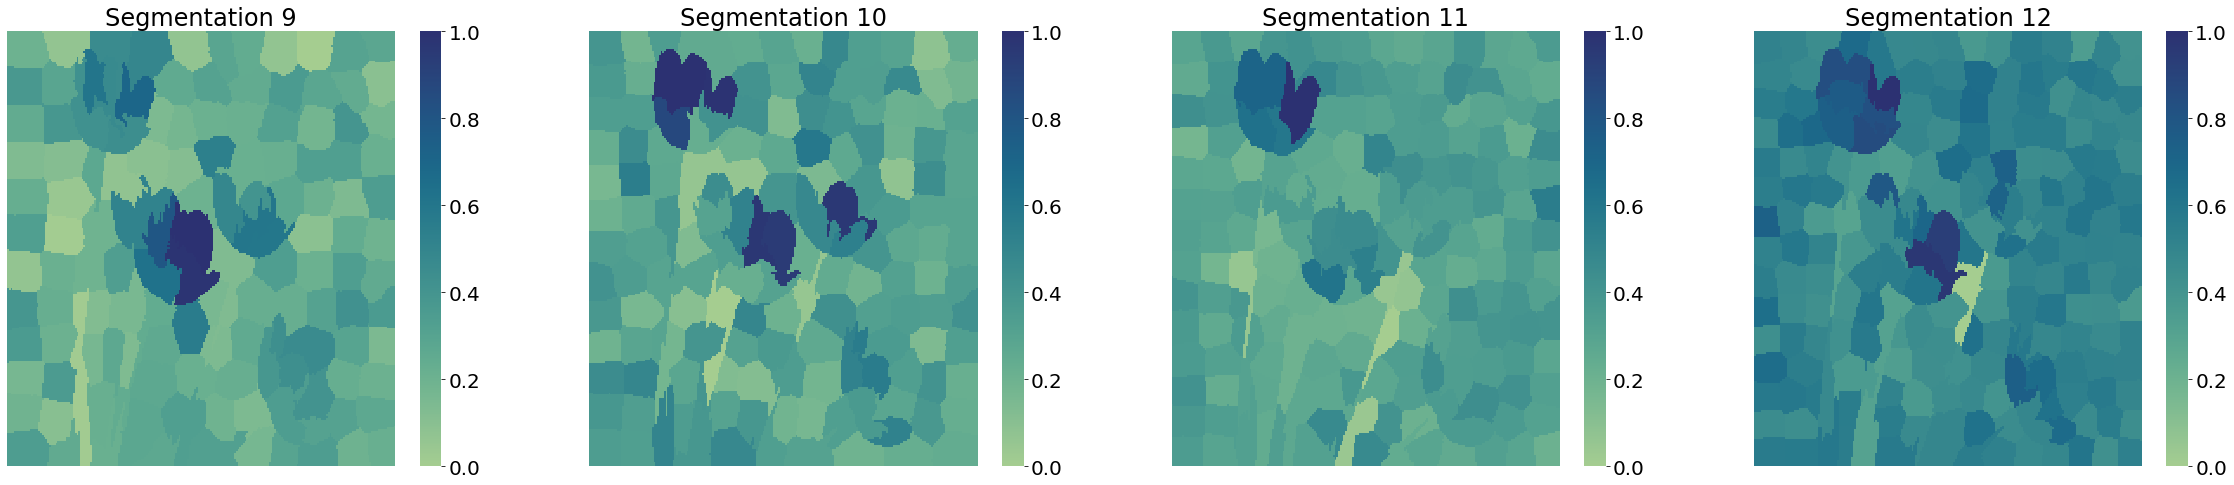

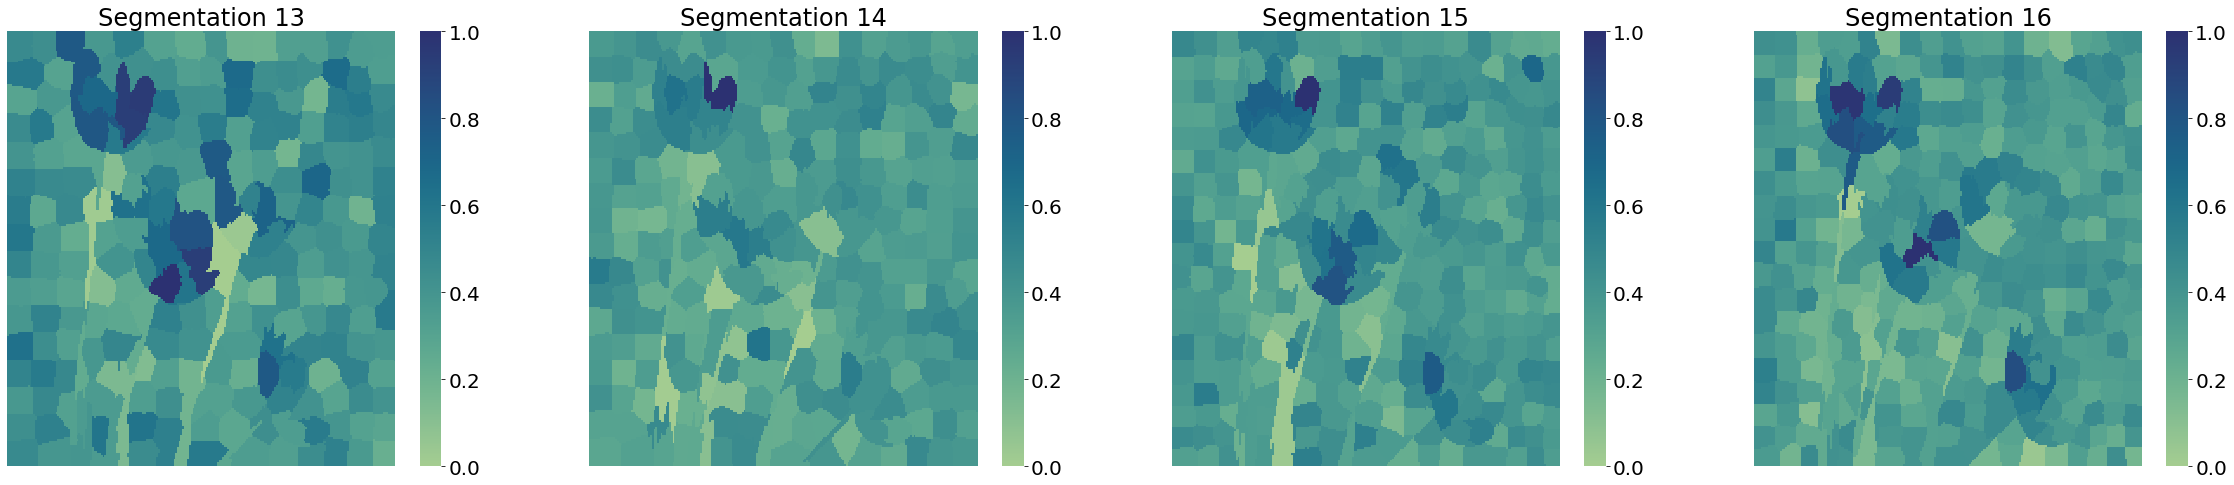

In [29]:
rcParams['figure.figsize'] = (40,8)
plt.rcParams["font.size"] = 20
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True)
h1 = sns.heatmap(multi_heatmaps[0],cmap='crest',cbar=True,ax=ax1)
h1.set_title('Segmentation 1')
h1.axis('off')
h2 = sns.heatmap(multi_heatmaps[1],cmap='crest',cbar=True,ax=ax2)
h2.set_title('Segmentation 2')
h2.axis('off')
h3 = sns.heatmap(multi_heatmaps[2],cmap='crest',cbar=True,ax=ax3)
h3.set_title('Segmentation 3')
h3.axis('off')
h4 = sns.heatmap(multi_heatmaps[3],cmap='crest',cbar=True,ax=ax4)
h4.set_title('Segmentation 4')
h4.axis('off')

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True)
h5 = sns.heatmap(multi_heatmaps[4],cmap='crest',cbar=True,ax=ax1)
h5.set_title('Segmentation 5')
h5.axis('off')
h6 = sns.heatmap(multi_heatmaps[5],cmap='crest',cbar=True,ax=ax2)
h6.set_title('Segmentation 6')
h6.axis('off')
h7 = sns.heatmap(multi_heatmaps[6],cmap='crest',cbar=True,ax=ax3)
h7.set_title('Segmentation 7')
h7.axis('off')
h8 = sns.heatmap(multi_heatmaps[7],cmap='crest',cbar=True,ax=ax4)
h8.set_title('Segmentation 8')
h8.axis('off')

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True)
h9 = sns.heatmap(multi_heatmaps[8],cmap='crest',cbar=True,ax=ax1)
h9.set_title('Segmentation 9')
h9.axis('off')
h10 = sns.heatmap(multi_heatmaps[9],cmap='crest',cbar=True,ax=ax2)
h10.set_title('Segmentation 10')
h10.axis('off')
h11 = sns.heatmap(multi_heatmaps[10],cmap='crest',cbar=True,ax=ax3)
h11.set_title('Segmentation 11')
h11.axis('off')
h12 = sns.heatmap(multi_heatmaps[11],cmap='crest',cbar=True,ax=ax4)
h12.set_title('Segmentation 12')
h12.axis('off')

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True)
h13 = sns.heatmap(multi_heatmaps[12],cmap='crest',cbar=True,ax=ax1)
h13.set_title('Segmentation 13')
h13.axis('off')
h14 = sns.heatmap(multi_heatmaps[13],cmap='crest',cbar=True,ax=ax2)
h14.set_title('Segmentation 14')
h14.axis('off')
h15 = sns.heatmap(multi_heatmaps[14],cmap='crest',cbar=True,ax=ax3)
h15.set_title('Segmentation 15')
h15.axis('off')
h16 = sns.heatmap(multi_heatmaps[15],cmap='crest',cbar=True,ax=ax4)
h16.set_title('Segmentation 16')
h16.axis('off');

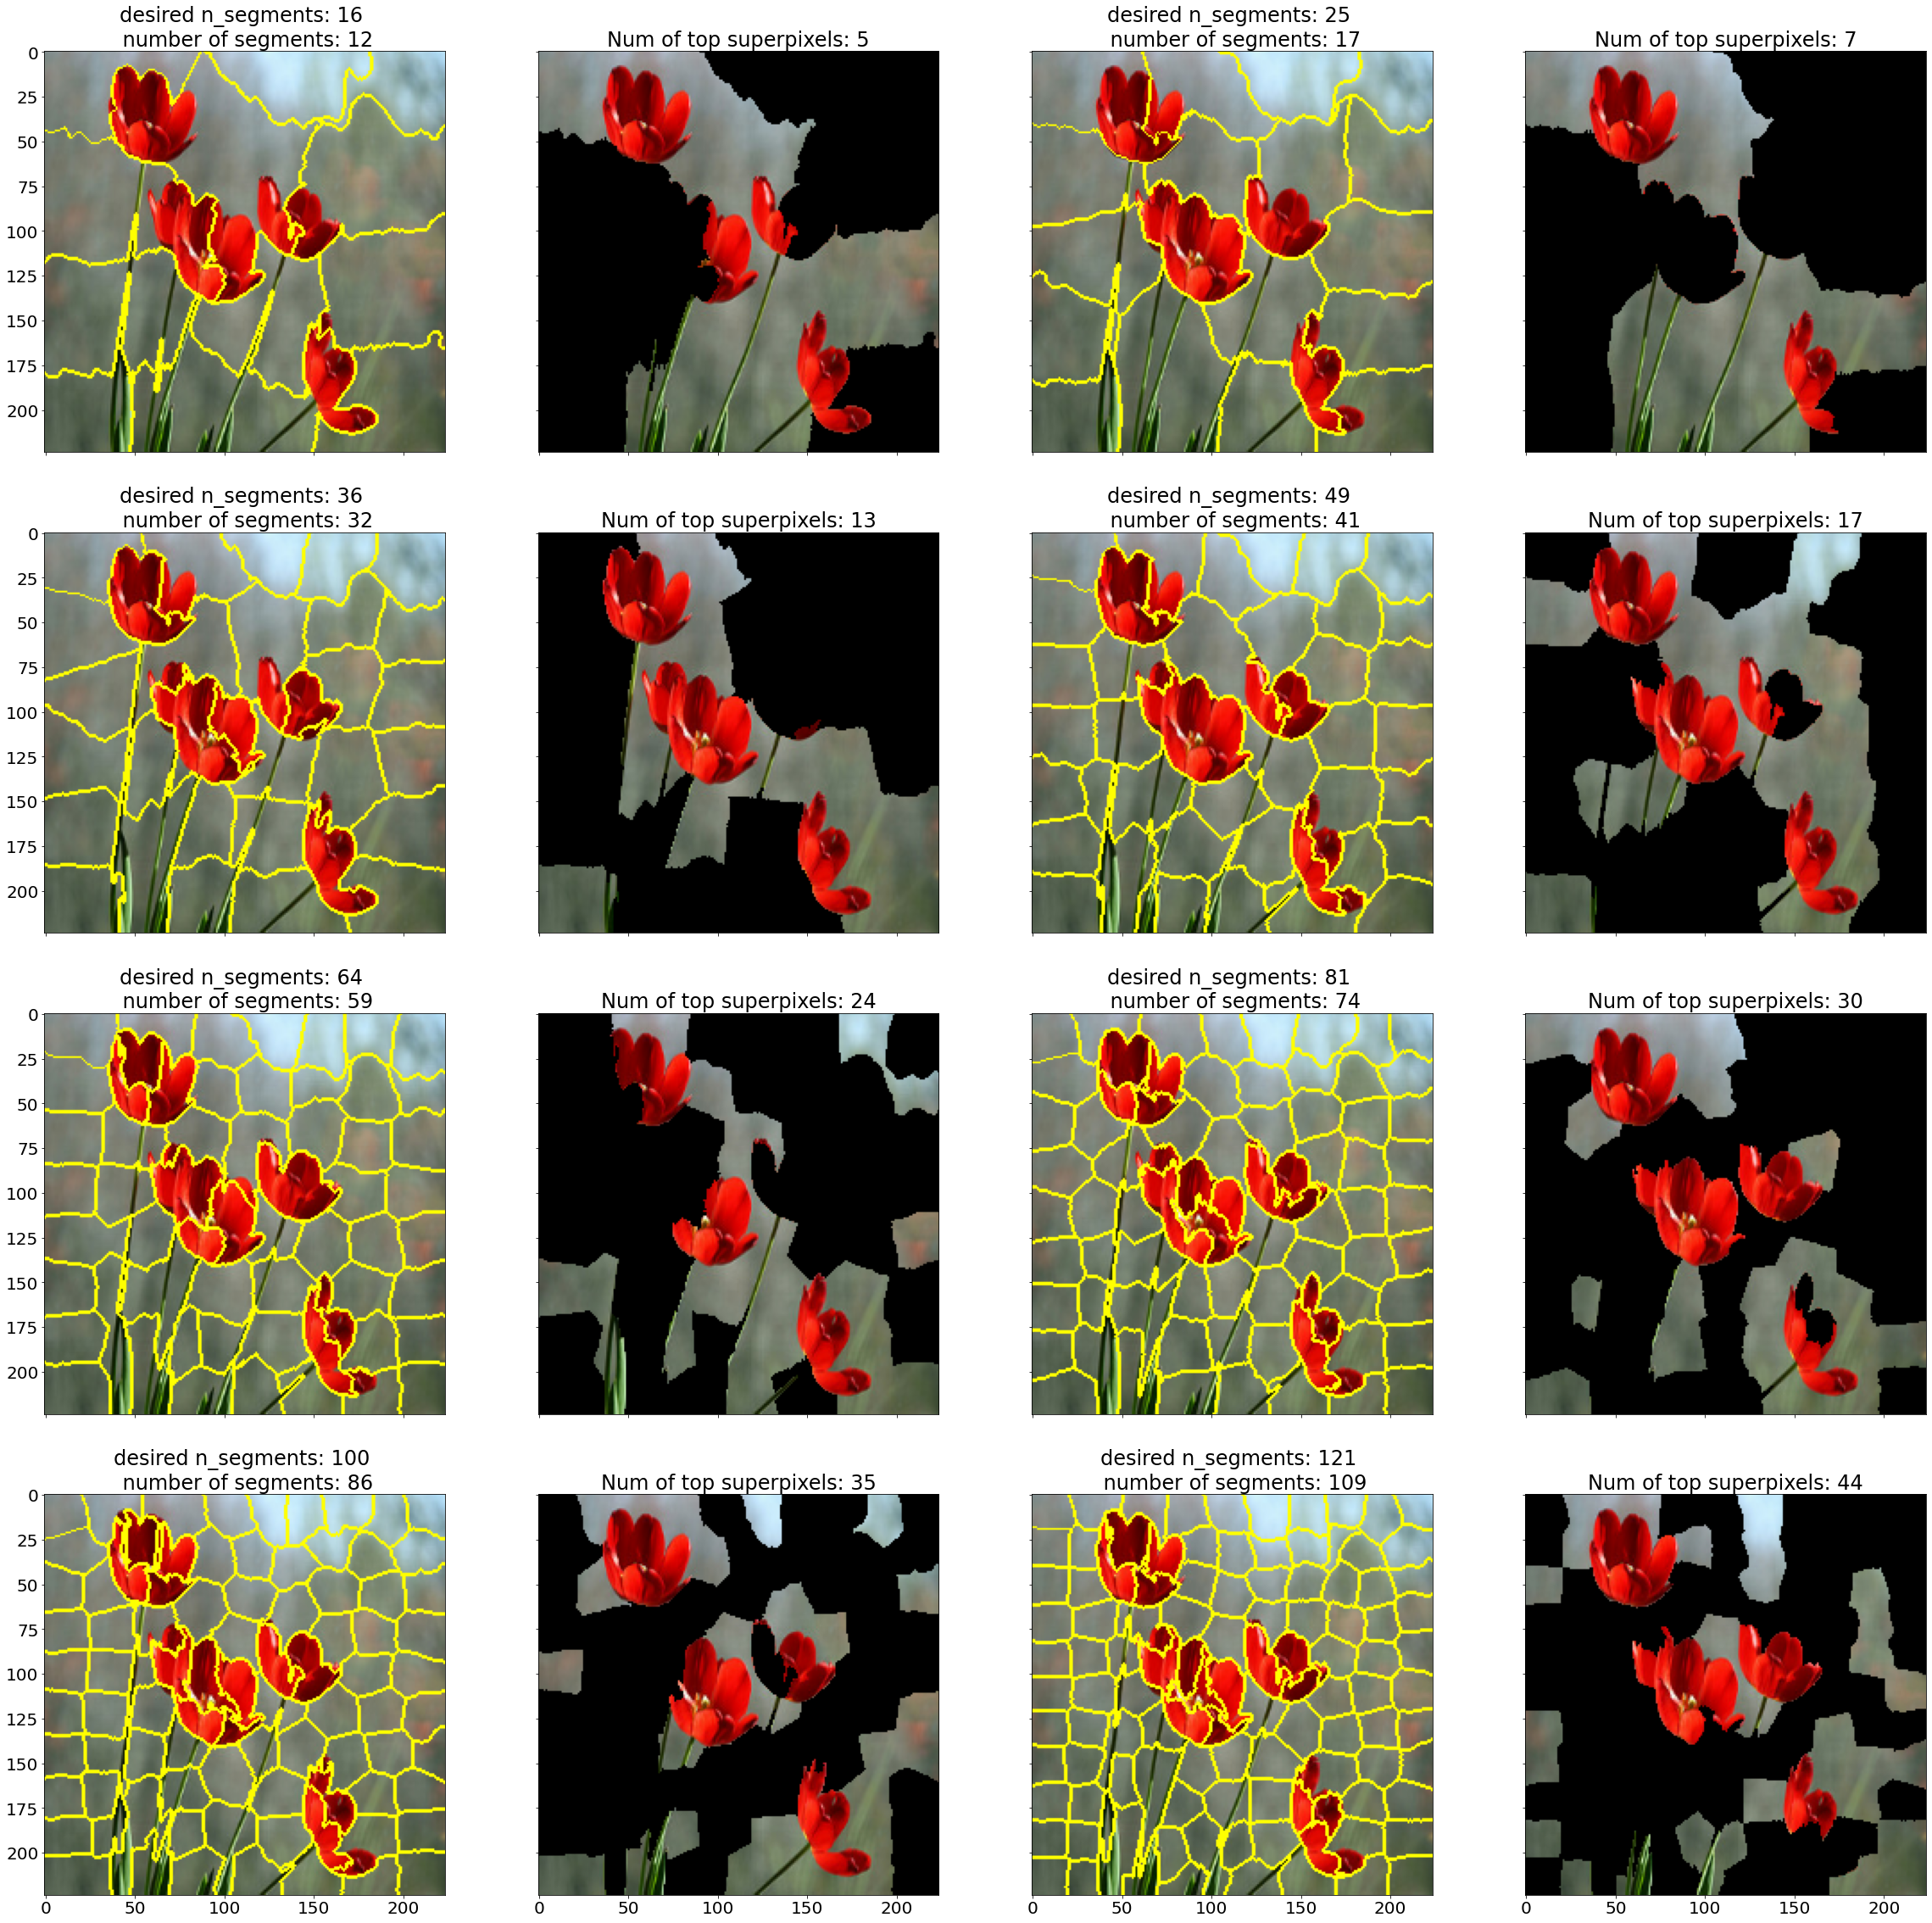

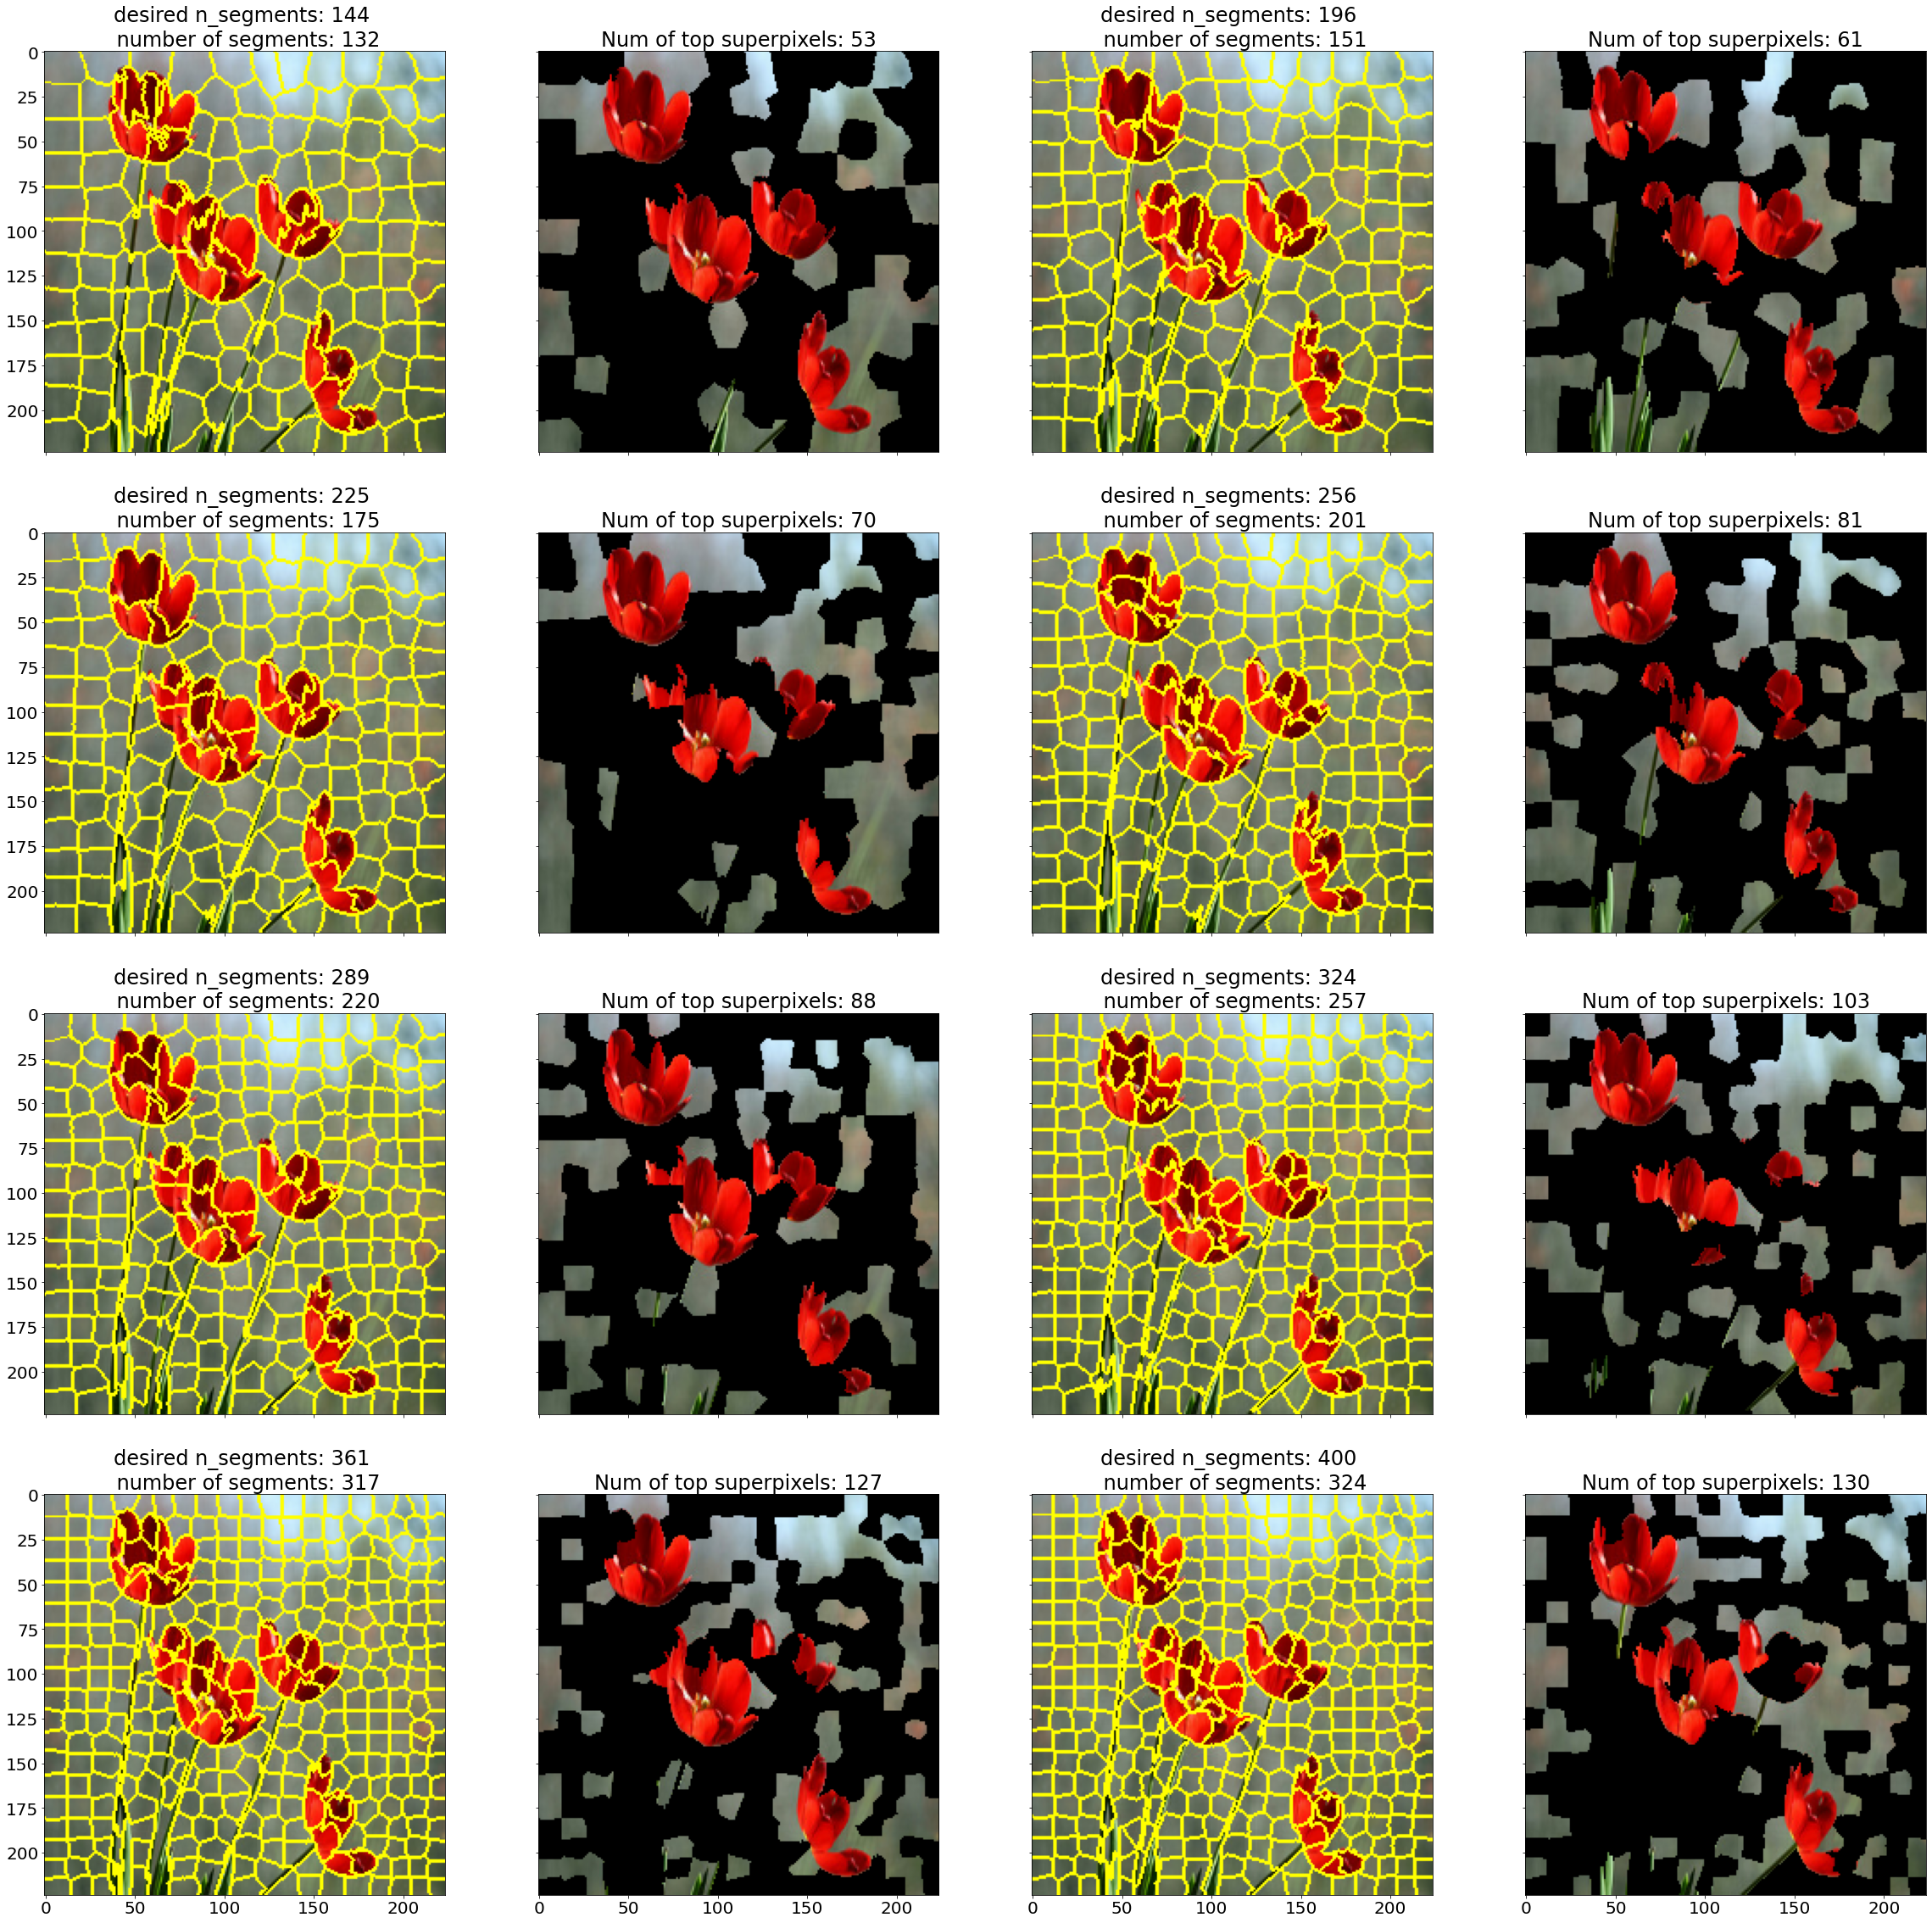

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(40,40), sharex=True, sharey=True)
plt.rcParams["font.size"] = 20
ax = axes.ravel()
ax[0].imshow(sb(test_image, seg1))
ax[0].set_title(f"desired n_segments: {16} \n number of segments: {n_seg1}")
ax[1].imshow(seg1_slic)
ax[1].set_title(f"Num of top superpixels: {top_f_seg1}")


ax[2].imshow(sb(test_image, seg2))
ax[2].set_title(f"desired n_segments: {25} \n number of segments: {n_seg2}")
ax[3].imshow(seg2_slic)
ax[3].set_title(f"Num of top superpixels: {top_f_seg2}")

ax[4].imshow(sb(test_image, seg3))
ax[4].set_title(f"desired n_segments: {36} \n number of segments: {n_seg3}")
ax[5].imshow(seg3_slic)
ax[5].set_title(f"Num of top superpixels: {top_f_seg3}")

ax[6].imshow(sb(test_image, seg4))
ax[6].set_title(f"desired n_segments: {49} \n number of segments: {n_seg4}")
ax[7].imshow(seg4_slic)
ax[7].set_title(f"Num of top superpixels: {top_f_seg4}")

ax[8].imshow(sb(test_image, seg5))
ax[8].set_title(f"desired n_segments: {64} \n number of segments: {n_seg5}")
ax[9].imshow(seg5_slic)
ax[9].set_title(f"Num of top superpixels: {top_f_seg5}")


ax[10].imshow(sb(test_image, seg6))
ax[10].set_title(f"desired n_segments: {81} \n number of segments: {n_seg6}")
ax[11].imshow(seg6_slic)
ax[11].set_title(f"Num of top superpixels: {top_f_seg6}")

ax[12].imshow(sb(test_image, seg7))
ax[12].set_title(f"desired n_segments: {100} \n number of segments: {n_seg7}")
ax[13].imshow(seg7_slic)
ax[13].set_title(f"Num of top superpixels: {top_f_seg7}")

ax[14].imshow(sb(test_image, seg8))
ax[14].set_title(f"desired n_segments: {121} \n number of segments: {n_seg8}")
ax[15].imshow(seg8_slic)
ax[15].set_title(f"Num of top superpixels: {top_f_seg8}")

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(40,40), sharex=True, sharey=True)
plt.rcParams["font.size"] = 20
ax = axes.ravel()
ax[0].imshow(sb(test_image, seg9))
ax[0].set_title(f"desired n_segments: {144} \n number of segments: {n_seg9}")
ax[1].imshow(seg9_slic)
ax[1].set_title(f"Num of top superpixels: {top_f_seg9}")

ax[2].imshow(sb(test_image, seg10))
ax[2].set_title(f"desired n_segments: {196} \n number of segments: {n_seg10}")
ax[3].imshow(seg10_slic)
ax[3].set_title(f"Num of top superpixels: {top_f_seg10}")

ax[4].imshow(sb(test_image, seg11))
ax[4].set_title(f"desired n_segments: {225} \n number of segments: {n_seg11}")
ax[5].imshow(seg11_slic)
ax[5].set_title(f"Num of top superpixels: {top_f_seg11}")

ax[6].imshow(sb(test_image, seg12))
ax[6].set_title(f"desired n_segments: {256} \n number of segments: {n_seg12}")
ax[7].imshow(seg12_slic)
ax[7].set_title(f"Num of top superpixels: {top_f_seg12}")

ax[8].imshow(sb(test_image, seg13))
ax[8].set_title(f"desired n_segments: {289} \n number of segments: {n_seg13}")
ax[9].imshow(seg13_slic)
ax[9].set_title(f"Num of top superpixels: {top_f_seg13}")

ax[10].imshow(sb(test_image, seg14))
ax[10].set_title(f"desired n_segments: {324} \n number of segments: {n_seg14}")
ax[11].imshow(seg14_slic)
ax[11].set_title(f"Num of top superpixels: {top_f_seg14}")

ax[12].imshow(sb(test_image, seg15))
ax[12].set_title(f"desired n_segments: {361} \n number of segments: {n_seg15}")
ax[13].imshow(seg15_slic)
ax[13].set_title(f"Num of top superpixels: {top_f_seg15}")

ax[14].imshow(sb(test_image, seg16))
ax[14].set_title(f"desired n_segments: {400} \n number of segments: {n_seg16}")
ax[15].imshow(seg16_slic)
ax[15].set_title(f"Num of top superpixels: {top_f_seg16}");

In [31]:
def visual_explanation(n,m,sigma,heatmaps):
    weighted_combination = 0
    r = range(-int(n/2),int(n/2)+1)
    weights = [1 / (sigma * sqrt(2*pi)) * exp(-float(x-m)**2/(2*sigma**2)) for x in r]
    weights = [x/sum(weights) for x in weights]
    for i in range(len(weights)):
        weighted_combination += weights[i]*(heatmaps[i])
    return weighted_combination

def gaussian_D(n,m,sigma):
    r = range(-int(n/2),int(n/2)+1)
    w = [1 / (sigma * sqrt(2*pi)) * exp(-float(x-m)**2/(2*sigma**2)) for x in r]
    w = [x/sum(w) for x in w]
    return w

In [32]:
gaussian_w1 = gaussian_D(5,0,5)
gaussian_w2 = gaussian_D(11,0,5)
gaussian_w3 = gaussian_D(7,0,5)

gaussian_w4 = gaussian_D(5,3,5)
gaussian_w5 = gaussian_D(11,6,5)
gaussian_w6 = gaussian_D(7,14,5)

In [33]:
weights_df = pd.DataFrame(data=[gaussian_w1,gaussian_w2,gaussian_w3], 
                          columns=['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11'],
                         index=['1','2','3']).rename_axis('Weights')
weights_df

W1        W2        W3        W4        W5        W6        W7  \
Weights                                                                         
1        0.192051  0.203926  0.208046  0.203926  0.192051       NaN       NaN   
2        0.066342  0.079425  0.091361  0.100969  0.107213  0.109379  0.107213   
3        0.128956  0.142518  0.151331  0.154388  0.151331  0.142518  0.128956   

               W8        W9       W10       W11  
Weights                                          
1             NaN       NaN       NaN       NaN  
2        0.100969  0.091361  0.079425  0.066342  
3             NaN       NaN       NaN       NaN

In [34]:
weights_df_2 = pd.DataFrame(data=[gaussian_w4,gaussian_w5,gaussian_w6], 
                          columns=['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11'],
                         index=['1','2','3']).rename_axis('Weights')
weights_df_2

W1        W2        W3        W4        W5        W6        W7  \
Weights                                                                         
1        0.148978  0.178360  0.205162  0.226739  0.240760       NaN       NaN   
2        0.015784  0.024023  0.035129  0.049354  0.066621  0.086403  0.107665   
3        0.014096  0.027273  0.050699  0.090550  0.155384  0.256184  0.405815   

               W8        W9       W10       W11  
Weights                                          
1             NaN       NaN       NaN       NaN  
2        0.128898  0.148268  0.163861  0.173994  
3             NaN       NaN       NaN       NaN

In [36]:
#### Explanations - Coarse & Fine scales

coarse_exp = []
for i in range(0,5):
    coarse_exp.append(multi_heatmaps[i])
    
fine_exp = []
for i in range(0,12):
    fine_exp.append(multi_heatmaps[i])
    
finest_exp = []
for i in range(10,len(multi_heatmaps)):
    finest_exp.append(multi_heatmaps[i])

explanation_coarse = visual_explanation(5,0,5,coarse_exp)
explanation_fine = visual_explanation(11,0,5,fine_exp)
explanation_finest = visual_explanation(7,0,5,finest_exp)

explanation_coarse = (explanation_coarse-np.min(explanation_coarse))/(np.max(explanation_coarse)-np.min(explanation_coarse))
explanation_fine = (explanation_fine-np.min(explanation_fine))/(np.max(explanation_fine)-np.min(explanation_fine))
explanation_finest = (explanation_finest-np.min(explanation_finest))/(np.max(explanation_finest)-np.min(explanation_finest))

exp_lime_coarse = cv2.addWeighted(explanation_coarse.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)
    
exp_lime_fine = cv2.addWeighted(explanation_fine.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)

exp_lime_finest = cv2.addWeighted(explanation_finest.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)

Localization of traditional LIME vs multi-scale scheme

In [37]:
superpixels_lime = ss.slic(test_image)
num_superpixels_lime = np.unique(superpixels_lime).shape[0]

weights_lime, samples_lime, predicted_probs_lime, seg_slic_lime, top_f_lime, features_lime, coeff_lime = xai_lime(test_image, superpixels_lime, num_superpixels_lime, top_class)
heatmap_lime = heatmap(features_lime, coeff_lime, superpixels_lime)

C:\Users\hoori\AppData\Local\Temp/ipykernel_23672/1385974470.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  superpixels_lime = ss.slic(test_image)


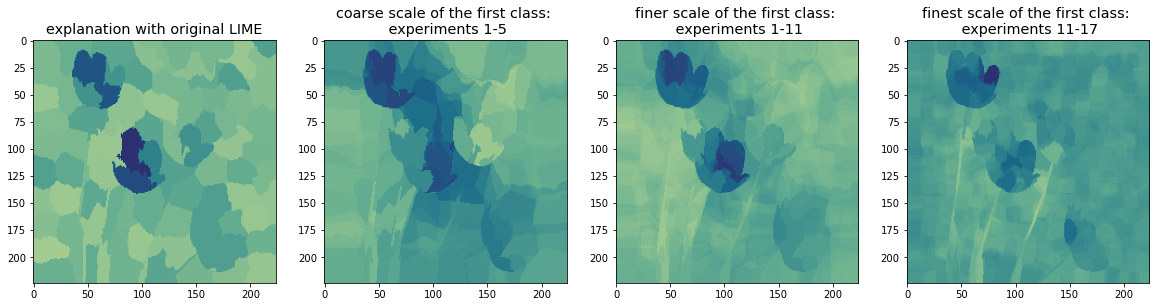

In [38]:
heatmap_lime_norm = (heatmap_lime-np.min(heatmap_lime))/(np.max(heatmap_lime-np.min(heatmap_lime)))
exp_lime = heatmap_lime_norm[...,np.newaxis] * test_image
exp_lime_superimposed = cv2.addWeighted(heatmap_lime_norm.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
plt.rcParams["font.size"] = 12
ax = axes.ravel()
ax[0].imshow(heatmap_lime_norm, cmap='crest')
ax[0].set_title('explanation with original LIME')
ax[1].imshow(explanation_coarse,cmap='crest')
ax[1].set_title("coarse scale of the first class: \n experiments 1-5")
ax[2].imshow(explanation_fine,cmap='crest')
ax[2].set_title("finer scale of the first class: \n experiments 1-11")
ax[3].imshow(explanation_finest,cmap='crest')
ax[3].set_title("finest scale of the first class: \n experiments 11-17");

# ax[4].imshow(exp_lime_superimposed)
# # ax[4].set_title('superimposed-traditional LIME')
# ax[5].imshow(exp_lime_coarse)
# # ax[5].set_title("superimposed scale 1")
# ax[6].imshow(exp_lime_fine)
# # ax[6].set_title("superimposed scale 2")
# ax[7].imshow(exp_lime_finest);
# # ax[7].set_title("Superimposed scale 3");

Explanation accuracy

In [39]:
exp_image_1 = test_image * explanation_coarse[..., np.newaxis]
exp_image_2 = test_image * explanation_fine[..., np.newaxis]
exp_image_3 = test_image * explanation_finest[..., np.newaxis]

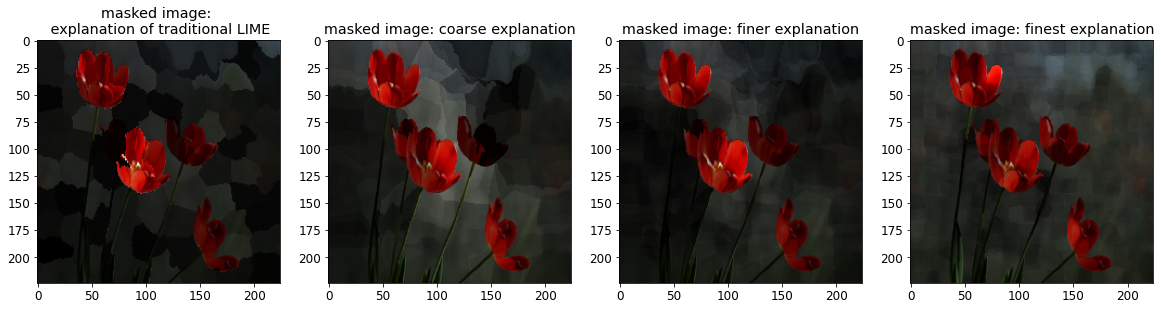

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,15))
plt.rcParams["font.size"] = 12
ax = axes.ravel()
ax[0].imshow(exp_lime)
ax[0].set_title(f'masked image: \n explanation of traditional LIME')
ax[1].imshow(exp_image_1)
ax[1].set_title(f'masked image: coarse explanation')
ax[2].imshow(exp_image_2)
ax[2].set_title(f'masked image: finer explanation')
ax[3].imshow(exp_image_3);
ax[3].set_title(f'masked image: finest explanation');